In [10]:
import subprocess
import os
import math
from functions.basefunctions import *
from collections import defaultdict
import numpy as np
import time 

kbT_RNA = 0.6163207755

In [11]:
import pickle

with open('../data/fRNAhammingdistance.pkl', 'rb') as f:
    fRNAhammingdistance = pickle.load(f)

with open('../data/fRNAprob2.pkl', 'rb') as f:
    fRNAprob2 = pickle.load(f)

with open('../data/fRNAprob1.pkl', 'rb') as f:
    fRNAprob1 = pickle.load(f)

with open('../data/fRNAfolds.pkl', 'rb') as f:
    fRNAfolds = pickle.load(f)
    
with open('../data/merged_dict.pkl', 'rb') as f:
    merged_dict= pickle.load(f)

In [12]:
len(fRNAhammingdistance), len(fRNAprob2)

(311016, 311016)

# Only left of the line from specific point, just to test
point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

These results are given in in data files 'site_scanning_probs_pval_seq_left'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


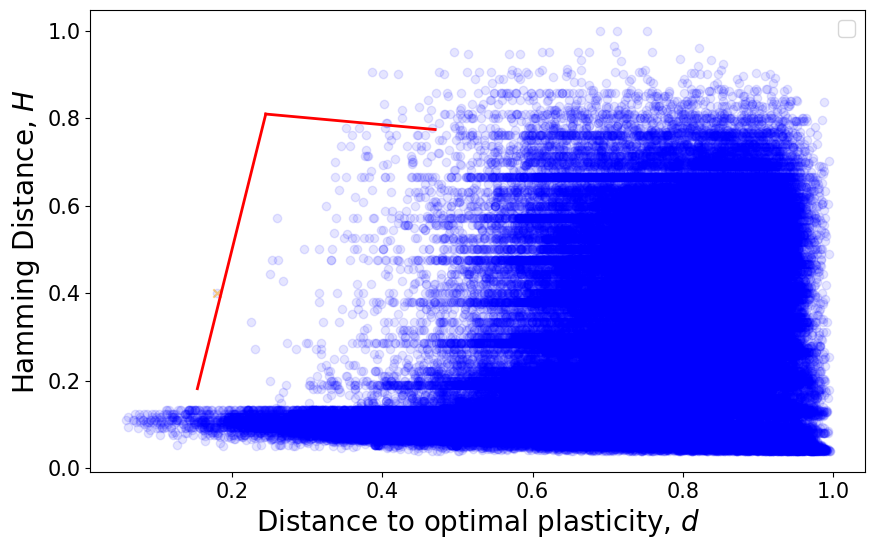

In [13]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/(np.sqrt(2)/2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

In [14]:
import glob
import pandas as pd
import re
import numpy as np
from scipy.stats import norm
from collections import defaultdict
import pickle
# Path to the data folder
data_folder = '../data/'

# Pattern to match the files
file_pattern = data_folder + 'site_scanning_probs_pval_seq_left*_ssize100000.pkl'

# List to store p-values from all files
nameandrankdist_hammingandprobs_pvals_left = defaultdict(dict)


files = glob.glob(file_pattern)

# Loop through each file and extract probs2
for file in files:
    match = re.search(r'site_scanning_probs_pval_seq_left(\d+)_ssize100000', file)
    
    if match:
        seq_number = int(match.group(1))
        # Read the file into a DataFrame
        with open(file, 'rb') as f:
            data = pickle.load(f)
        
        # Extract probs2 and append to the list
        probs2 = list(data['probs2'])
        observed_value = fRNAprob2[tuple(left_names[seq_number])]  # Replace with your specific value
        
        mean = np.mean(probs2)
        std_dev = np.std(probs2)

        # Compute the z-score for the observed value
        z_score = (observed_value - mean) / std_dev

        # One-tailed p-value (upper-tail)
        p_value_upper = 1 - norm.cdf(z_score)
        if p_value_upper < 0.05:
            print(seq_number, tuple(left_names[seq_number]), p_value_upper)
            nameandrankdist_hammingandprobs_pvals_left[tuple(left_names[seq_number])][(fRNAhammingdistance[tuple(left_names[seq_number])],fRNAprob1[tuple(left_names[seq_number])],fRNAprob2[tuple(left_names[seq_number])])] = p_value_upper
    


IndexError: index 32 is out of bounds for axis 0 with size 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


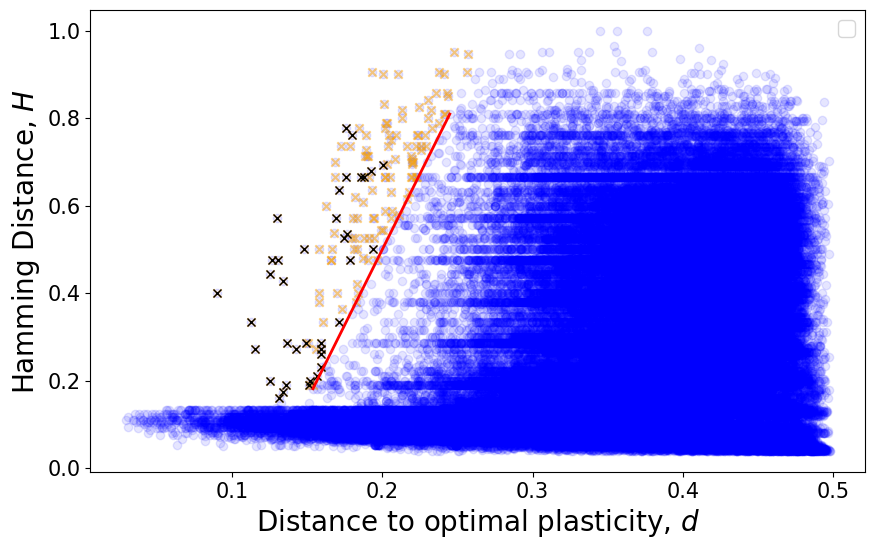

In [5]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/(np.sqrt(2)/2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
#plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

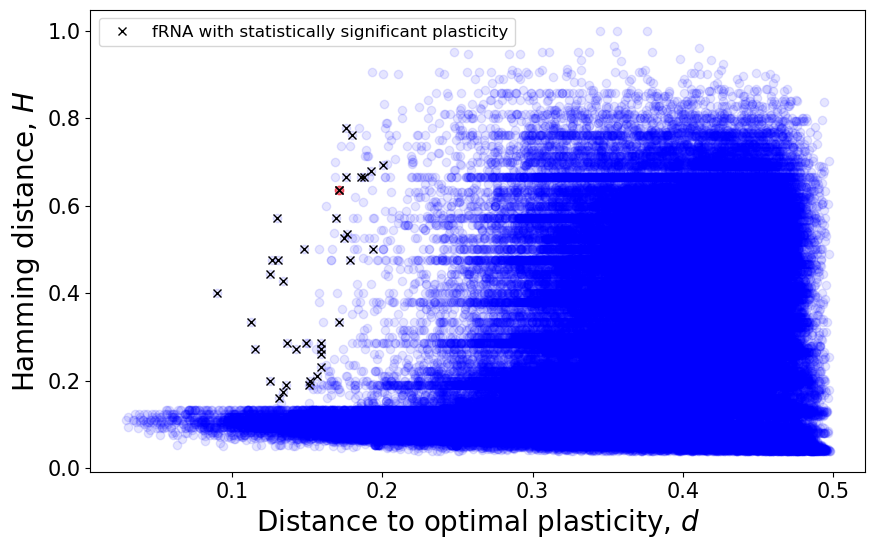

In [6]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
name = tuple(left_names[22])

observed_value_distance = diagonal_distances[name]
observed_value_hamming = fRNAhammingdistance[name]
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(observed_value_distance, observed_value_hamming, c='red', marker='o', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
    if name == tuple(left_names[22]):
        plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black', label='fRNA with statistically significant plasticity')
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
#plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
#plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=12)
# Show the plot
plt.show()

In [7]:
#example for seq 0
import pickle
with open('../data/site_scanning_probs_pval_seq_left_minus_bottom_ssize10000.pkl', 'rb') as f:
    site_scanning_probs_pval_seq_left22_ssize10000 = pickle.load(f)
probs2 = site_scanning_probs_pval_seq_left22_ssize10000['probs2']

# Plot the distributions
name = tuple(left_names[22])
print(name)
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 2)
plt.hist(probs2, bins=50, alpha=0.7, color='red')
plt.xlabel(r'$P_1$',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title('Site-Scanning Distribution',fontsize=12)

seq_number = 22
# Read the file into a DataFrame
with open('../data/site_scanning_probs_pval_seq_left22_ssize10000.pkl', 'rb') as f:
    data = pickle.load(f)

# Extract probs2 and append to the list
probs2 = list(data['probs2'])
observed_value = fRNAprob2[tuple(left_names[seq_number])]  # Replace with your specific value

mean = np.mean(probs2)
std_dev = np.std(probs2)

# Compute the z-score for the observed value
z_score = (observed_value - mean) / std_dev

# One-tailed p-value (upper-tail)
pval = 1 - norm.cdf(z_score)

observed_value = fRNAprob2[name]
print(observed_value)
print(pval)
plt.axvline(x=observed_value, color='black', linestyle='--',label= r'p-value='+str(np.round(pval,2)))
#plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/site_scanning_probs_pval_seq_left_minus_bottom_ssize10000.pkl'

# Now get a wider range of points
 can we optimise such that all points are tested?

In [8]:
with open(f"../data/selected_names_left_minus_a.pkl","rb") as f:
        left_names_minus = pickle.load(f)

In [9]:
import glob
import pandas as pd
import re
import numpy as np
from scipy.stats import norm
from collections import defaultdict
import pickle
# Path to the data folder
data_folder = '../data/'

# Pattern to match the files
file_pattern = data_folder + 'site_scanning_probs_pval_seq_left_minus*_ssize10000.pkl'

# List to store p-values from all files
nameandrankdist_hammingandprobs_pvals_left_minus = defaultdict(dict)


files = glob.glob(file_pattern)

# Loop through each file and extract probs2
for file in files:
    match = re.search(r'site_scanning_probs_pval_seq_left_minus(\d+)_ssize10000', file)
    
    if match:
        seq_number = int(match.group(1))
        # Read the file into a DataFrame
        with open(file, 'rb') as f:
            data = pickle.load(f)
        
        # Extract probs2 and append to the list
        probs2 = list(data['probs2'])
        observed_value = fRNAprob2[tuple(left_names_minus[seq_number])]  # Replace with your specific value
        
        mean = np.mean(probs2)
        std_dev = np.std(probs2)

        # Compute the z-score for the observed value
        z_score = (observed_value - mean) / std_dev

        # One-tailed p-value (upper-tail)
        p_value_upper = 1 - norm.cdf(z_score)
        if p_value_upper < 0.05:
            print(seq_number, tuple(left_names_minus[seq_number]), p_value_upper)
            nameandrankdist_hammingandprobs_pvals_left_minus[tuple(left_names_minus[seq_number])][(fRNAhammingdistance[tuple(left_names_minus[seq_number])],fRNAprob1[tuple(left_names_minus[seq_number])],fRNAprob2[tuple(left_names_minus[seq_number])])] = p_value_upper
    


656 ('FR457228||Fly small RNA', 'GCCGAGGGCGCAGCCGAGGA') 0.049036400556988546
680 ('FR459166||Fly small RNA', 'GCTTGATAGCCATTGTTATCCTTTGC') 0.02791640365784831
174 ('FR358593||Putative conserved noncoding region (EvoFold)', 'ACTGCATGATAACATGCTGT') 0.03555157771168149
303 ('FR420090||Fly small RNA', 'AGCAGAGTGGCGCAGT') 0.049596973545311895
436 ('FR434991||Fly small RNA', 'CAGTCTCCTCGGAGGCGTGGGT') 0.028053601598315714
192 ('FR399371||Putative conserved noncoding region (EvoFold)', 'CTCATGGGGGATCTCATGCAG') 0.02789355245181857
346 ('FR423319||Fly small RNA', 'AGTTGCAGCAGAGCGGCAATG') 0.03686749986524396
389 ('FR430704||Fly small RNA', 'CAAAAGCAGTCATCTGAAGGC') 0.04746318376594083
960 ('FR499661||Fly small RNA', 'TTCGAGCCTCACCCGGGGCATGTAC') 0.02826508141252515
42 ('FR085158|DQ570753|Piwi-interacting RNA (piRNA)', 'AGAAGGTGAAAACCAAGGACCTAGGAAA') 0.03925232506746368
236 ('FR412944||Fly small RNA', 'AAGTGGCATCAAGGCCTTCTGG') 0.03851993708588941
235 ('FR412834||Fly small RNA', 'AAGTCGAGCAGCAGGTTCCA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


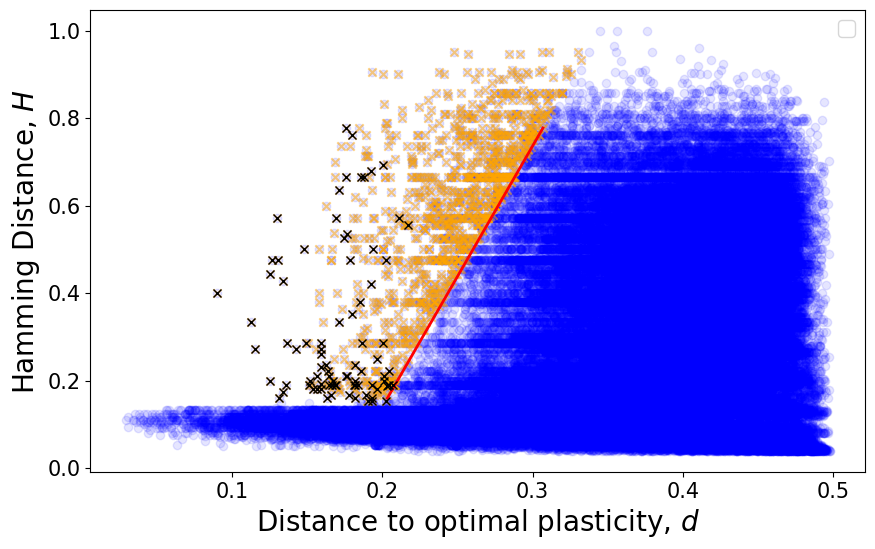

In [10]:
from matplotlib import pyplot as plt 
import numpy as np

diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
point0 = (0.30688980382826875,0.7777777777777778) #('FR481122||Fly small RNA', 'TCGAATCCGAAGATTGCA') 0.30688980382826875 0.7777777777777778
point1 =  (0.20333026388667144,0.16)

m= (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point1[1] - m * point1[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line



left_names_tot = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')

# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()



# bottom range

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


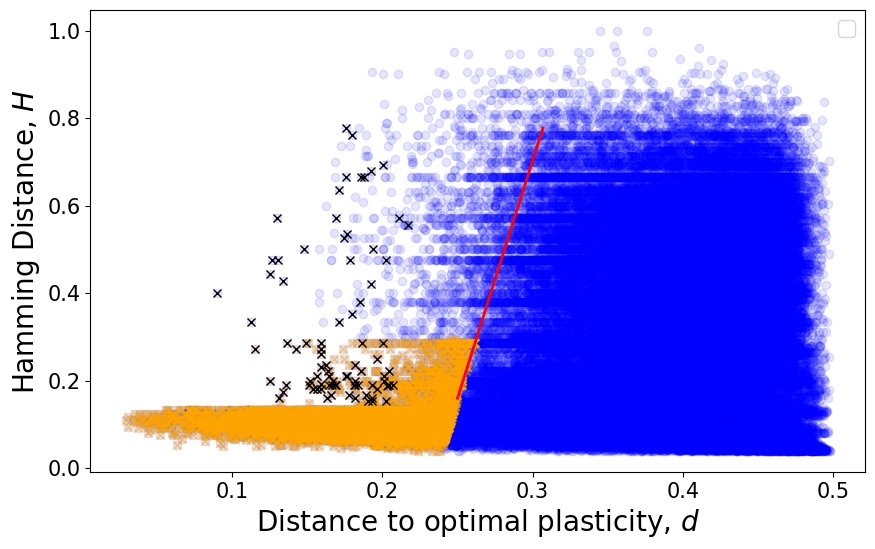

In [11]:
from matplotlib import pyplot as plt 
import numpy as np

diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
point0 = (0.30688980382826875,0.7777777777777778) #('FR481122||Fly small RNA', 'TCGAATCCGAAGATTGCA') 0.30688980382826875 0.7777777777777778
point1 =  (0.25,0.16)

m= (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point1[1] - m * point1[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.3):
    return h < h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line




left_names_tot_bottom= selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
#for name in nameandrankdist_hammingandprobs_pvals_left_minus_bottom.keys():
#    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')

# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

In [12]:
left_names_minus_bottom = []
for i in left_names_tot_bottom:
    if i in left_names or i in left_names_tot: continue
    else: left_names_minus_bottom.append(i)



In [13]:
len(left_names_minus_bottom)

15617

In [14]:
import glob
import pandas as pd
import re
import numpy as np
from scipy.stats import norm
from collections import defaultdict
import pickle
# Path to the data folder
data_folder = '../data/'

# Pattern to match the files
file_pattern = data_folder + 'site_scanning_probs_pval_seq_left_minus_bottom*_ssize10000.pkl'

# List to store p-values from all files
nameandrankdist_hammingandprobs_pvals_left_minus_bottom = defaultdict(dict)


files = glob.glob(file_pattern)
#with open(f"../data/selected_names_left_minus_bottom.pkl","rb") as f:
#    left_names = pickle.load(f)
left_names = left_names_minus_bottom
# Loop through each file and extract probs2
for file in files:
    match = re.search(r'site_scanning_probs_pval_seq_left_minus_bottom(\d+)_ssize10000', file)
    if match:
        seq_number = int(match.group(1))
        # Read the file into a DataFrame
        with open(file, 'rb') as f:
            data = pickle.load(f)
        
        # Extract probs2 and append to the list
        probs2 = list(data['probs2'])
        observed_value = fRNAprob2[tuple(left_names[seq_number])]  # Replace with your specific value
        
        mean = np.mean(probs2)
        std_dev = np.std(probs2)

        # Compute the z-score for the observed value
        z_score = (observed_value - mean) / std_dev

        # One-tailed p-value (upper-tail)
        p_value_upper = 1 - norm.cdf(z_score)
        if p_value_upper < 0.05:
            print(seq_number, tuple(left_names[seq_number]), p_value_upper)
            nameandrankdist_hammingandprobs_pvals_left_minus_bottom[tuple(left_names[seq_number])][(fRNAhammingdistance[tuple(left_names[seq_number])],fRNAprob1[tuple(left_names[seq_number])],fRNAprob2[tuple(left_names[seq_number])])] = p_value_upper

2389 ('FR093272||Putative conserved noncoding region (EvoFold)', 'TCAACACATTCAAGTGTTGA') 0.007904001773462399
2673 ('FR103899|DQ729348|Piwi-interacting RNA (piRNA)', 'TGAGGCAAAAAGGCGTCGTGGG') 0.00031688304622512486
1443 ('FR057564||Putative conserved noncoding region (EvoFold)', 'TGAATTAATTCTGCTTTAATTCA') 0.014730486160312029
4978 ('FR190917||Putative conserved noncoding region (EvoFold)', 'AGTCAGGTCTCCTGACT') 0.033842423826581536
3857 ('FR147843|AF042843,AF113937,AF113938,AF113939|Prion pseudoknot', 'CCACGGTGGTGGCTGGGGACAGCCACATGGTGGTGGTGGT') 0.01345468480297729
3441 ('FR132049||Putative conserved noncoding region (EvoFold)', 'CTGCTTAAAATTTAAGCAG') 0.04190729118267311
2032 ('FR080367||Putative conserved noncoding region (EvoFold)', 'CTGGGCATGGTGCCCAG') 0.026923018872220927
2500 ('FR097667||Putative conserved noncoding region (EvoFold)', 'TTGTACAATGTACAA') 0.011173371314847413
858 ('FR035143||Putative conserved noncoding region (EvoFold)', 'TGACATCTGAAAATGGGGATGTCA') 0.0012589532359418

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


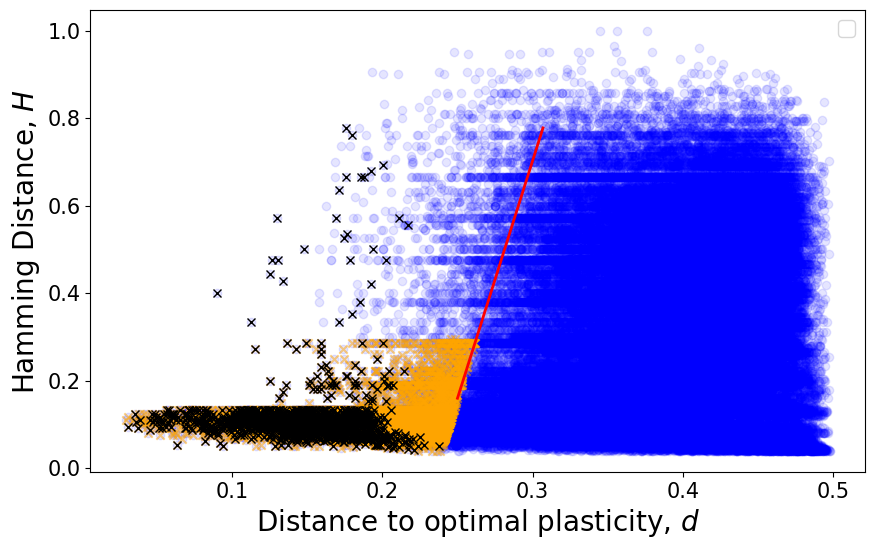

In [15]:
from matplotlib import pyplot as plt 
import numpy as np

diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
point0 = (0.30688980382826875,0.7777777777777778) #('FR481122||Fly small RNA', 'TCGAATCCGAAGATTGCA') 0.30688980382826875 0.7777777777777778
point1 =  (0.25,0.16)

m= (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point1[1] - m * point1[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.3):
    return h < h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line




left_names_tot_bottom= selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus_bottom.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')

# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

# fRNA significant length

In [16]:
merged_dict = {**nameandrankdist_hammingandprobs_pvals_left, **nameandrankdist_hammingandprobs_pvals_left_minus,**nameandrankdist_hammingandprobs_pvals_left_minus_bottom}

In [17]:
len (merged_dict)

1440

In [18]:
with open('../data/merged_dict.pkl', 'wb') as f:
    pickle.dump(merged_dict, f)

In [19]:
import pickle
with open('../data/merged_dict.pkl', 'rb') as f:
    merged_dict = pickle.load(f)

In [20]:
sorted_merged_dict = dict(sorted(merged_dict.items(), key=lambda item: list(item[1].values())[0]))


In [21]:
count = -1
sigBH = {}
for k,v in sorted_merged_dict.items():
    count+=1
    sigBH[k] = v
    if count == 146: break

In [34]:
sigBH

{('FR001310|D16617|Hepatitis C stem-loop IV',
  'CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT'): {(0.05405405405405406,
   0.43645017760912713,
   0.43645017760912713): 1.0672731692973336e-05},
 ('FR141231|AY133057|Prion pseudoknot',
  'TCATGGTGGCGGCTGGGGACAGCCCCACGGTGGTGGTTGG'): {(0.05,
   0.4284960795800685,
   0.3877192862857611): 1.638896049149796e-05},
 ('FR164768||Putative conserved noncoding region (EvoFold)',
  'TGCTGAGCGACGAGCTCAGCA'): {(0.09523809523809523,
   0.5044924708712456,
   0.4564836647617196): 5.627165687782654e-05},
 ('FR176351||Putative conserved noncoding region (EvoFold)',
  'TGACGTGGAGGACACGTCA'): {(0.10526315789473684,
   0.49649550637707696,
   0.4492477120566908): 6.924576395883619e-05},
 ('FR026182||Putative conserved noncoding region (EvoFold)',
  'TGGTTCTGTCTTGAACCA'): {(0.1111111111111111,
   0.4927602949545851,
   0.4458679529973449): 7.243888095720408e-05},
 ('FR040058||Putative conserved noncoding region (EvoFold)',
  'TGGCGCCTGGTCACAGGTGCCA'): {(0.090909090

In [25]:
values_list = [list(inner_dict.values())[0] for inner_dict in sorted_merged_dict.values()]


In [26]:
values_list

[1.0672731692973336e-05,
 1.638896049149796e-05,
 5.627165687782654e-05,
 6.924576395883619e-05,
 7.243888095720408e-05,
 7.580966282905166e-05,
 9.135799502535402e-05,
 0.00014124901662160294,
 0.000141882070533339,
 0.00015018596745819401,
 0.0001608766093128544,
 0.00016868346226595055,
 0.00017046820032018406,
 0.0001748177380540561,
 0.000177443803850319,
 0.00018690302269241954,
 0.0002136524555030883,
 0.00022769652959986342,
 0.00023127239534703747,
 0.00023168914282989395,
 0.00023520971212742658,
 0.0002445645175559452,
 0.0002455067336293304,
 0.00024709246775722615,
 0.0002505698512201837,
 0.0002516407193067227,
 0.0002566765381003533,
 0.00027110366088600735,
 0.00027584291568072405,
 0.0002844516193409863,
 0.000312820154610316,
 0.0003132587080685312,
 0.00031688304622512486,
 0.00032025507202415593,
 0.0003242054464638322,
 0.0003393328238293636,
 0.0003400422473185394,
 0.00034472598034196444,
 0.00036200642090011836,
 0.00037984190944184704,
 0.0003846529418114475,
 

# Statistical error

In [27]:
import numpy as np

def find_first_false_streak(comparison):
    for idx in range(len(comparison)):
        if all(not val for val in comparison[idx:]):
            return idx
    return None

def false_discovery_control(ps, *, axis=0, method='bh'):

    ps = np.asarray(ps)
    if method == 'bh':
        # Benjamini-Hochberg procedure
        shape = ps.shape
        ps = np.sort(ps, axis=axis)
        n = ps.shape[axis]
        i = np.arange(1, n + 1)
        threshold = 0.1*i/ 7150
        comparison = ps <= threshold
        false_indices = np.where(comparison == False)[0]
        first_false_streak_index = find_first_false_streak(comparison)
        if first_false_streak_index is not None:
            print(f"Index where comparison becomes consistently False: {first_false_streak_index}")
        else:
            print("No consistent False streak found in comparison")
        return comparison
    else:
        raise ValueError(f"Unknown method: {method}")

# Example usage
p_values = values_list
comparison = false_discovery_control(p_values, method='bh')
print(comparison)

Index where comparison becomes consistently False: 145
[ True  True False ... False False False]


# Length of RNA analysis

In [38]:
siglengthRNA = []
sighammingRNA = []
sigdistRNA = []
signame = []
for name in merged_dict.keys():
    siglengthRNA.append(len(name[1]))
    sighammingRNA.append(fRNAhammingdistance[name])
    sigdistRNA.append(diagonal_distances[name])
    signame.append(name)

In [39]:
len(signame)

1440

In [40]:
lengthRNA = []
for name in selected_names:
    lengthRNA.append(len(name[1]))


KeyboardInterrupt: 

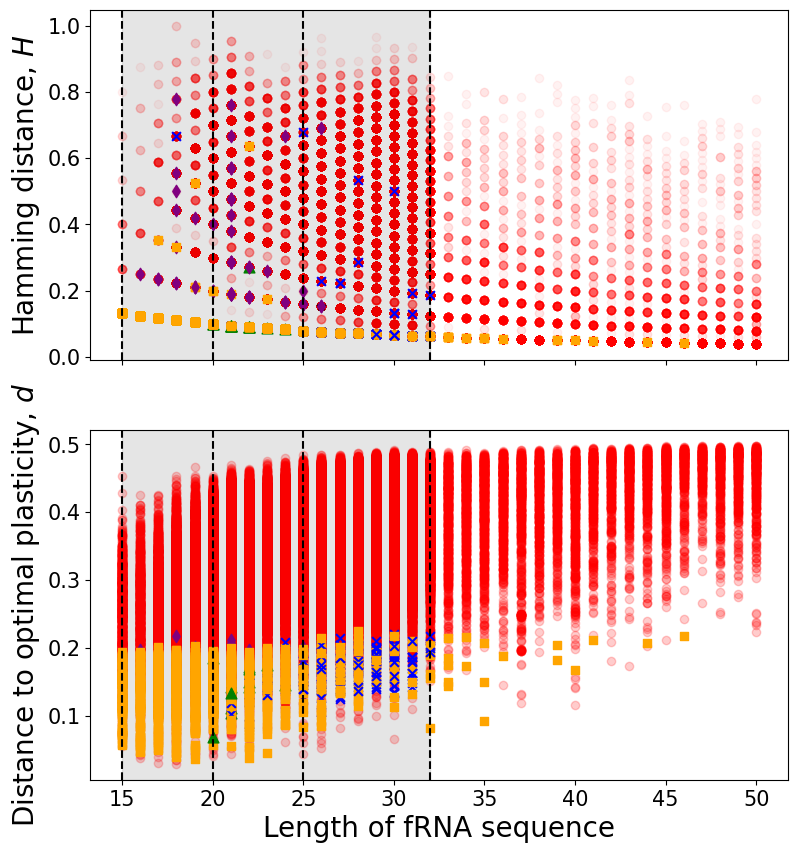

In [41]:
import matplotlib.pyplot as plt

# Sample data for demonstration

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 10),sharex=True)
# Add grey backgrounds

ax1.axvline(x=15, color='black', linestyle='--')
ax1.axvline(x=20, color='black', linestyle='--')
ax1.axvline(x=25, color='black', linestyle='--')
ax1.axvline(x=32, color='black', linestyle='--')


ax2.axvline(x=15, color='black', linestyle='--')
ax2.axvline(x=20, color='black', linestyle='--')
ax2.axvline(x=25, color='black', linestyle='--')
ax2.axvline(x=32, color='black', linestyle='--')
"""
ax1.axvspan(15, 20, color='grey', alpha=0.3)
ax1.axvspan(20, 25, color='grey', alpha=0.7)
ax1.axvspan(25, 32, color='grey', alpha=0.9)

ax2.axvspan(15, 20, color='grey', alpha=0.3)
ax2.axvspan(20, 25, color='grey', alpha=0.7)
ax2.axvspan(25, 32, color='grey', alpha=0.9)
"""
ax1.axvspan(15, 32, color='grey', alpha=0.2)
ax2.axvspan(15, 32, color='grey', alpha=0.2)



# First subplot
otherlengthRNA = []
otherhammingRNA = []
otherdistRNA = []
for i in range(0,len(selected_names)):
    name =tuple(selected_names[i])
    if name not in signame:
        otherlengthRNA.append(len(name[1]))
        otherhammingRNA.append(fRNAhammingdistance[name])
        otherdistRNA.append(diagonal_distances[name])

ax1.scatter(otherlengthRNA, otherhammingRNA, c='red', marker='o', alpha=0.05, label='other fRNA')
#ax1.scatter(siglengthRNA, sighammingRNA, c='black', marker='o', alpha=1.0)
#ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='blue', marker='o', alpha=1.0, label='(miRNA) miR-27a-3p')
ax2.scatter(otherlengthRNA, otherdistRNA, c='red', marker='o', alpha=0.2)
#ax2.scatter(siglengthRNA, sigdistRNA, c='black', marker='o', alpha=1.0)

#ax1.set_xlabel('Length of fRNA sequence', fontsize=20)
ax1.set_ylabel('Hamming distance, $H$', fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

ax2.set_xlabel('Length of fRNA sequence', fontsize=20)
ax2.set_ylabel('Distance to optimal plasticity, $d$', fontsize=20)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# Second subplot
#name = ('FR258706||mature micro RNA (miRNA) miR-27a-3p', 'TTCACAGTGGCTAAGTTCCGCC')

for name in signame:
 
    
    if 'EvoFold' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='orange', marker='s',s =40, alpha=1.0, label='EvoFold conserved region')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='orange', marker='s',s =40, alpha=1.0, label='EvoFold conserved region')
    if 'Fly small RNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='purple', marker='d',s =40, alpha=1.0, label='Fly small RNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='purple', marker='d', s=40,alpha=1.0, label='Fly small RNA')
    if 'Histone' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='black', marker='*',s =40, alpha=1.0, label='Histone 3\' UTR stem-loop')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='black', marker='*',s =40, alpha=1.0, label='Histone 3\' UTR stem-loop')
    if 'piRNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='blue', marker='x',s=40, alpha=1.0, label='piRNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='blue', marker='x', s=40,alpha=1.0, label='piRNA')
    if 'miRNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='green', marker='^',s =60, alpha=1.0, label='miRNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='green', marker='^',s =60, alpha=1.0, label='miRNA')

#ax2.scatter(len(name[1]), diagonal_distances[name], c='blue', marker='o', alpha=1.0, label='(miRNA) miR-27a-3p')

#ax2.legend(fontsize=15)
handles, labels = [], []
for ax in [ax1, ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.92), fontsize=15)
# Show the plot
plt.tight_layout()
plt.show()

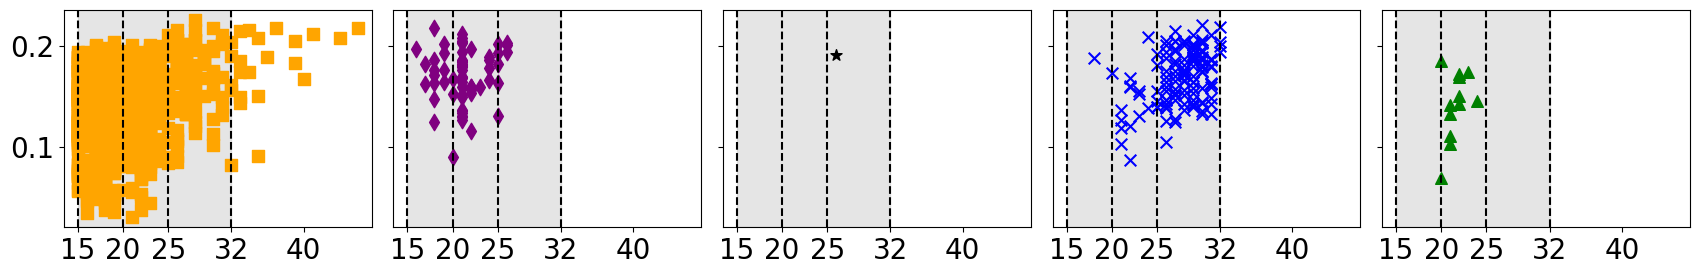

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(18, 3), sharex=True, sharey=True)

# Define the types and their corresponding colors and markers
types = [
    ('EvoFold', 'orange', 's', 'EvoFold conserved region'),
    ('Fly small RNA', 'purple', 'd', 'Fly small RNA'),
    ('Histone', 'black', '*', 'Histone 3\' UTR stem-loop'),
    ('piRNA', 'blue', 'x', 'piRNA'),
    ('miRNA', 'green', '^', 'miRNA')
]

# Track which labels have been added
added_labels = set()

for ax, (type_name, color, marker, label) in zip(axs, types):
    ax.axvline(x=15, color='black', linestyle='--')
    ax.axvline(x=20, color='black', linestyle='--')
    ax.axvline(x=25, color='black', linestyle='--')
    ax.axvline(x=32, color='black', linestyle='--')
    ax.axvspan(15, 32, color='grey', alpha=0.2)
    ax.set_xticks([15, 20, 25, 32, 40])
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    for name in signame:
        if type_name in name[0]:
            if label not in added_labels:
                ax.scatter(len(name[1]), diagonal_distances[name], c=color, marker=marker, s=70, alpha=1.0, label=label)
                added_labels.add(label)
            else:
                ax.scatter(len(name[1]), diagonal_distances[name], c=color, marker=marker, s=70, alpha=1.0)
    
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.7), fontsize=15)

#fig.text(0.5, 0.01, 'Length of RNA', ha='center', fontsize=18)
#fig.text(0.04, 0.5, r'Distance to optimal plasticity, $d$', va='center', rotation='vertical', fontsize=18)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

# compare MFE and subopt

In [44]:
names_merged = [name for name in merged_dict.keys()]
mfe_merged = [fRNAfolds[name][0] for name in names_merged]
subopt_merged = [fRNAfolds[name][1] for name in names_merged]

In [45]:
tuples = []
for mfe,subopt in zip(mfe_merged,subopt_merged):
    tuples.append((mfe,subopt))

In [46]:
with open("tuples.pkl","wb") as f:
    pickle.dump(tuples,f)

In [47]:
with open('names.pkl','wb') as f:
    pickle.dump(names_merged,f)

quantify how often a subopt of fRNA in MFE of another fRNA,

In [48]:
from collections import Counter
from collections import defaultdict

mfe_elements_tot = [tup[0] for tup in fRNAfolds.values() if '.' * len(tup[0]) not in tup]
subopt_elements_tot = [tup[1] for tup in fRNAfolds.values() if '.' * len(tup[1]) not in tup]
names_elements_tot = [name for name in fRNAfolds.keys() if '.' * len(fRNAfolds[name][0]) not in fRNAfolds[name]]

names_merged = [name for name in merged_dict.keys()]
mfe_merged = [fRNAfolds[name][0] for name in names_merged]
subopt_merged = [fRNAfolds[name][1] for name in names_merged]


names_elements_tot_minus_merged = [name for name in names_elements_tot if name not in names_merged]
mfe_elements_tot_minus_merged = [fRNAfolds[name][0] for name in names_elements_tot_minus_merged]
subopt_elements_tot_minus_merged = [fRNAfolds[name][1] for name in names_elements_tot_minus_merged]
count_mfe_elements_tot_minus_merged = Counter(mfe_elements_tot_minus_merged)
count_subopt_elements_tot_minus_merged = Counter(subopt_elements_tot_minus_merged)

count_mfe_elements_merged = Counter(mfe_merged)
count_subopt_elements_merged = Counter(subopt_merged)

Find complementary sequences: fRNAs that have unlikely plasticity, do these share structural motifs? why would they? how can I measure this?

count how many times an mfe appears as suboptimal, and how many times a suboptimal appears as mfe

In [49]:
mfe_to_subopt_merged = defaultdict(tuple)
subopt_to_mfe_merged = defaultdict(tuple)
mfe_to_subopt_merged_mfename = []
mfe_to_subopt_merged_suboptname = []
mfe_to_subopt_merged_structure = []
for name_mfe_merged in list(merged_dict.keys()):
    for suboptimal, suboptimalname in zip(subopt_merged, names_merged):
        if fRNAfolds[name_mfe_merged][0] == suboptimal:
            #print(name_mfe_merged,':',fRNAfolds[name_mfe_merged],'and', suboptimalname,':',fRNAfolds[suboptimalname])
            mfe_to_subopt_merged_mfename.append(name_mfe_merged)
            mfe_to_subopt_merged_suboptname.append(suboptimalname)
            mfe_to_subopt_merged_structure.append(suboptimal)
            
subopt_to_mfe_merged_suboptname = []
subopt_to_mfe_merged_mfename = []
subopt_to_mfe_merged_structure = []

for name_subopt_merged in list(merged_dict.keys()):
    for mfe, mfename in zip(mfe_merged, names_merged):
        if fRNAfolds[name_subopt_merged][1] == mfe:
            #print(name_subopt_merged,':',fRNAfolds[name_subopt_merged],'and', mfename,':',fRNAfolds[mfename])
            subopt_to_mfe_merged_suboptname.append(name_subopt_merged)
            subopt_to_mfe_merged_mfename.append(mfename)
            subopt_to_mfe_merged_structure.append(mfe)

In [50]:
from collections import defaultdict

complementary2fRNAs = []
unique_tuples = set()

for i in range(len(mfe_to_subopt_merged_mfename)):
    name_mfe = mfe_to_subopt_merged_mfename[i]
    suboptname = mfe_to_subopt_merged_suboptname[i]
    for j in range(len(subopt_to_mfe_merged_suboptname)):
        name_subopt = subopt_to_mfe_merged_suboptname[j]
        mfename = subopt_to_mfe_merged_mfename[j]
        if name_mfe == name_subopt and suboptname == mfename:
            print(name_mfe, suboptname)
            print(fRNAfolds[name_mfe], 'and', fRNAfolds[suboptname])
            normalized_tuple = tuple(sorted((name_mfe, suboptname)))
            if normalized_tuple not in unique_tuples:
                unique_tuples.add(normalized_tuple)
                complementary2fRNAs.append(normalized_tuple)


('FR050025||Putative conserved noncoding region (EvoFold)', 'GTACCTGTGAGTTAGGAAC') ('FR463621||Fly small RNA', 'GTCCATCGCCCAGGTGTAC')
['...((((.....))))...', '((.((((.....)))).))'] and ['((.((((.....)))).))', '...((((.....))))...']
('FR463621||Fly small RNA', 'GTCCATCGCCCAGGTGTAC') ('FR050025||Putative conserved noncoding region (EvoFold)', 'GTACCTGTGAGTTAGGAAC')
['((.((((.....)))).))', '...((((.....))))...'] and ['...((((.....))))...', '((.((((.....)))).))']
('FR093272||Putative conserved noncoding region (EvoFold)', 'TCAACACATTCAAGTGTTGA') ('FR004843||Putative conserved noncoding region (EvoFold)', 'TTACAGTTTCTATATTGTAA')
['(((((((......)))))))', '.((((((......)))))).'] and ['.((((((......)))))).', '(((((((......)))))))']
('FR093272||Putative conserved noncoding region (EvoFold)', 'TCAACACATTCAAGTGTTGA') ('FR132857||Putative conserved noncoding region (EvoFold)', 'TTCATTAAATGGCTAATGAA')
['(((((((......)))))))', '.((((((......)))))).'] and ['.((((((......)))))).', '(((((((......))))))

('FR184631||Putative conserved noncoding region (EvoFold)', 'TGCTGTTCCACAGCA') ('FR097667||Putative conserved noncoding region (EvoFold)', 'TTGTACAATGTACAA')
['((((((...))))))', '.(((((...))))).'] and ['.(((((...))))).', '((((((...))))))']
('FR184631||Putative conserved noncoding region (EvoFold)', 'TGCTGTTCCACAGCA') ('FR076592||Putative conserved noncoding region (EvoFold)', 'TTCTTCCTGGAAGAA')
['((((((...))))))', '.(((((...))))).'] and ['.(((((...))))).', '((((((...))))))']
('FR184631||Putative conserved noncoding region (EvoFold)', 'TGCTGTTCCACAGCA') ('FR056742||Putative conserved noncoding region (EvoFold)', 'TTCCACTGTGTGGAA')
['((((((...))))))', '.(((((...))))).'] and ['.(((((...))))).', '((((((...))))))']
('FR184631||Putative conserved noncoding region (EvoFold)', 'TGCTGTTCCACAGCA') ('FR001383||Putative conserved noncoding region (EvoFold)', 'TTTCTGAAACAGAAA')
['((((((...))))))', '.(((((...))))).'] and ['.(((((...))))).', '((((((...))))))']
('FR184631||Putative conserved noncoding

KeyboardInterrupt: 

In [38]:
unique_tuples_1D = [item for tup in unique_tuples for item in tup]

In [39]:
unique_tuples_1D = Counter(unique_tuples_1D)

In [40]:
unique_tuples_1D.keys()

dict_keys([('FR038734||Putative conserved noncoding region (EvoFold)', 'TGGTTTTTAGTTTAAAACCA'), ('FR132857||Putative conserved noncoding region (EvoFold)', 'TTCATTAAATGGCTAATGAA'), ('FR020909||Putative conserved noncoding region (EvoFold)', 'TTACTGATATTTTAGTAA'), ('FR058510||Putative conserved noncoding region (EvoFold)', 'ACCTGAGCTACCTCAGGT'), ('FR032901||Putative conserved noncoding region (EvoFold)', 'ACTTCCTGAGGAAGGAAGT'), ('FR132953||Putative conserved noncoding region (EvoFold)', 'TTAATGTAAGAAACATTAA'), ('FR073371||Putative conserved noncoding region (EvoFold)', 'ACATCCTTTGGATGT'), ('FR159522||Putative conserved noncoding region (EvoFold)', 'TTCAGCAGGGCTGAA'), ('FR066653||Putative conserved noncoding region (EvoFold)', 'TCCTCCGGGGAGGGGGA'), ('FR082451||Putative conserved noncoding region (EvoFold)', 'TCTGCTGATTAAGCAGG'), ('FR020873||Putative conserved noncoding region (EvoFold)', 'TGATCTTGGGGATCA'), ('FR088991||Putative conserved noncoding region (EvoFold)', 'TTGTTCTTTGAACAA'), (

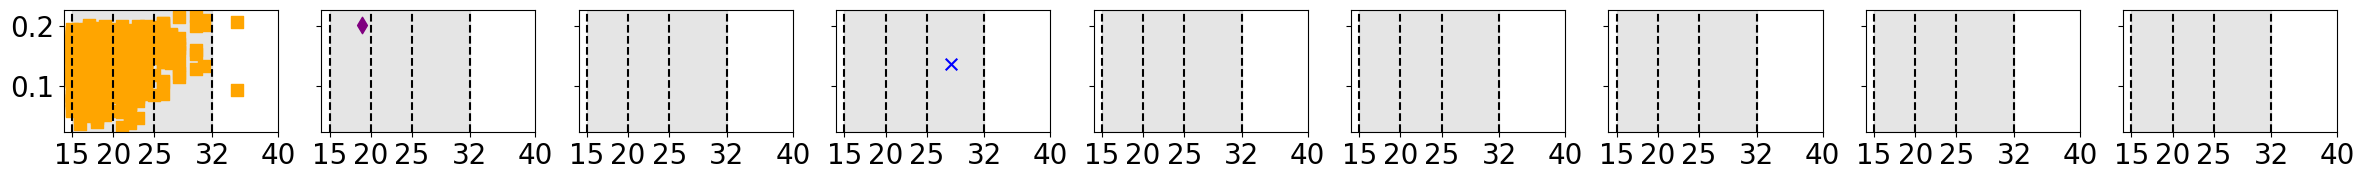

In [41]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 9, figsize=(25, 2), sharex=True, sharey=True)

# Define the types and their corresponding colors and markers
types = [
    ('EvoFold', 'orange', 's', 'EvoFold conserved region'),
    ('Fly small RNA', 'purple', 'd', 'Fly small RNA'),
    ('Histone', 'black', '*', 'Histone 3\' UTR stem-loop'),
    ('piRNA', 'blue', 'x', 'piRNA'),
    ('miRNA', 'green', '^', 'miRNA'),
    ('Hepatitis', 'red', 's', 'Hepatitis C stem-loop IV'),
    ('bronchitis','blue', 'd', 'Infectious bronchitis virus D-RNA'),
    ('TAR', 'brown', '*', 'HIV-1 TAR RNA'),
    ('Prion pseudoknot', 'orange', 'x', 'Prion pseudoknot')
]

# Track which labels have been added
added_labels = set()

for ax, (type_name, color, marker, label) in zip(axs, types):
    ax.axvline(x=15, color='black', linestyle='--')
    ax.axvline(x=20, color='black', linestyle='--')
    ax.axvline(x=25, color='black', linestyle='--')
    ax.axvline(x=32, color='black', linestyle='--')
    ax.axvspan(15, 32, color='grey', alpha=0.2)
    ax.set_xticks([15, 20, 25, 32, 40])
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    for name in signame:
        if type_name in name[0] and name in list(unique_tuples_1D.keys()):
            if label not in added_labels:
                ax.scatter(len(name[1]), diagonal_distances[name], c=color, marker=marker, s=70, alpha=1.0, label=label)
                added_labels.add(label)
            else:
                ax.scatter(len(name[1]), diagonal_distances[name], c=color, marker=marker, s=70, alpha=1.0)

    
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.7), fontsize=15)

#fig.text(0.5, 0.01, 'Length of RNA', ha='center', fontsize=18)
#fig.text(0.04, 0.5, r'Distance to optimal plasticity, $d$', va='center', rotation='vertical', fontsize=18)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()    

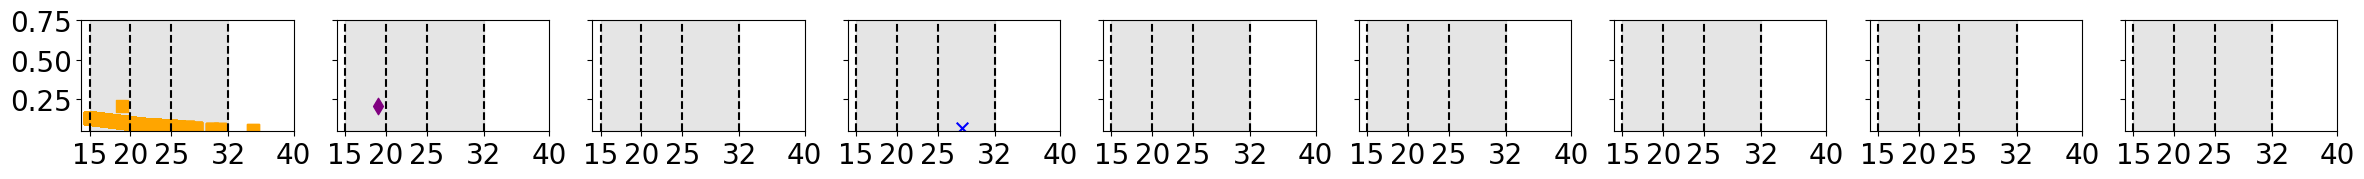

In [42]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 9, figsize=(25, 2), sharex=True, sharey=True)

# Define the types and their corresponding colors and markers
types = [
    ('EvoFold', 'orange', 's', 'EvoFold conserved region'),
    ('Fly small RNA', 'purple', 'd', 'Fly small RNA'),
    ('Histone', 'black', '*', 'Histone 3\' UTR stem-loop'),
    ('piRNA', 'blue', 'x', 'piRNA'),
    ('miRNA', 'green', '^', 'miRNA'),
    ('Hepatitis', 'red', 's', 'Hepatitis C stem-loop IV'),
    ('bronchitis','blue', 'd', 'Infectious bronchitis virus D-RNA'),
    ('TAR', 'brown', '*', 'HIV-1 TAR RNA'),
    ('Prion pseudoknot', 'orange', 'x', 'Prion pseudoknot')
]

# Track which labels have been added
added_labels = set()

for ax, (type_name, color, marker, label) in zip(axs, types):
    ax.axvline(x=15, color='black', linestyle='--')
    ax.axvline(x=20, color='black', linestyle='--')
    ax.axvline(x=25, color='black', linestyle='--')
    ax.axvline(x=32, color='black', linestyle='--')
    ax.axvspan(15, 32, color='grey', alpha=0.2)
    ax.set_xticks([15, 20, 25, 32, 40])
    ax.set_yticks([0.25,0.50,0.75])
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    for name in signame:
        if type_name in name[0] and name in list(unique_tuples_1D.keys()):
            if label not in added_labels:
                ax.scatter(len(name[1]), fRNAhammingdistance[name], c=color, marker=marker, s=70, alpha=1.0, label=label)
                added_labels.add(label)
            else:
                ax.scatter(len(name[1]), fRNAhammingdistance[name], c=color, marker=marker, s=70, alpha=1.0)

    
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.7), fontsize=15)

#fig.text(0.5, 0.01, 'Length of RNA', ha='center', fontsize=18)
#fig.text(0.04, 0.5, r'Distance to optimal plasticity, $d$', va='center', rotation='vertical', fontsize=18)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()    

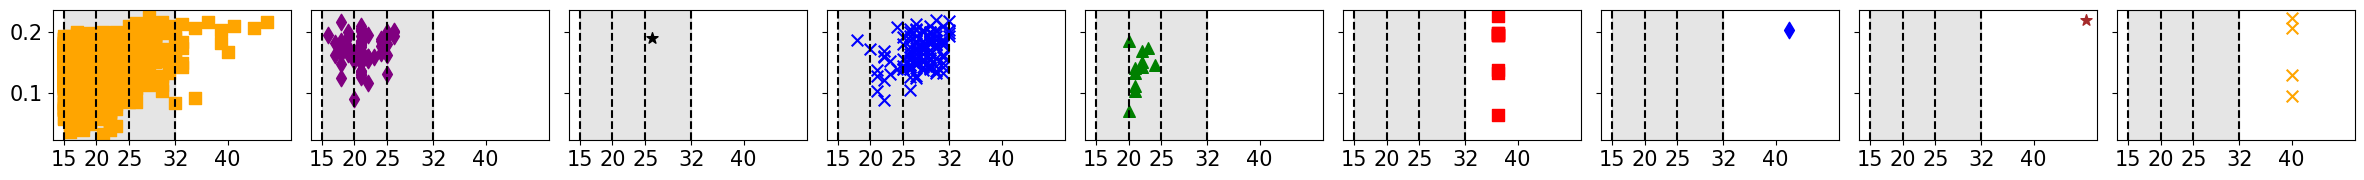

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 9, figsize=(25, 2), sharex=True, sharey=True)

# Define the types and their corresponding colors and markers
types = [
    ('EvoFold', 'orange', 's', 'EvoFold conserved region'),
    ('Fly small RNA', 'purple', 'd', 'Fly small RNA'),
    ('Histone', 'black', '*', 'Histone 3\' UTR stem-loop'),
    ('piRNA', 'blue', 'x', 'piRNA'),
    ('miRNA', 'green', '^', 'miRNA'),
    ('Hepatitis', 'red', 's', 'Hepatitis C stem-loop IV'),
    ('bronchitis','blue', 'd', 'Infectious bronchitis virus D-RNA'),
    ('TAR', 'brown', '*', 'HIV-1 TAR RNA'),
    ('Prion pseudoknot', 'orange', 'x', 'Prion pseudoknot')
]

# Track which labels have been added
added_labels = set()

for ax, (type_name, color, marker, label) in zip(axs, types):
    ax.axvline(x=15, color='black', linestyle='--')
    ax.axvline(x=20, color='black', linestyle='--')
    ax.axvline(x=25, color='black', linestyle='--')
    ax.axvline(x=32, color='black', linestyle='--')
    ax.axvspan(15, 32, color='grey', alpha=0.2)
    ax.set_xticks([15, 20, 25, 32, 40])
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
    for name in signame:
        if type_name in name[0]:
            if label not in added_labels:
                ax.scatter(len(name[1]), diagonal_distances[name], c=color, marker=marker, s=70, alpha=1.0, label=label)
                added_labels.add(label)
            else:
                ax.scatter(len(name[1]), diagonal_distances[name], c=color, marker=marker, s=70, alpha=1.0)

    
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.7), fontsize=15)

#fig.text(0.5, 0.01, 'Length of RNA', ha='center', fontsize=18)
#fig.text(0.04, 0.5, r'Distance to optimal plasticity, $d$', va='center', rotation='vertical', fontsize=18)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()    

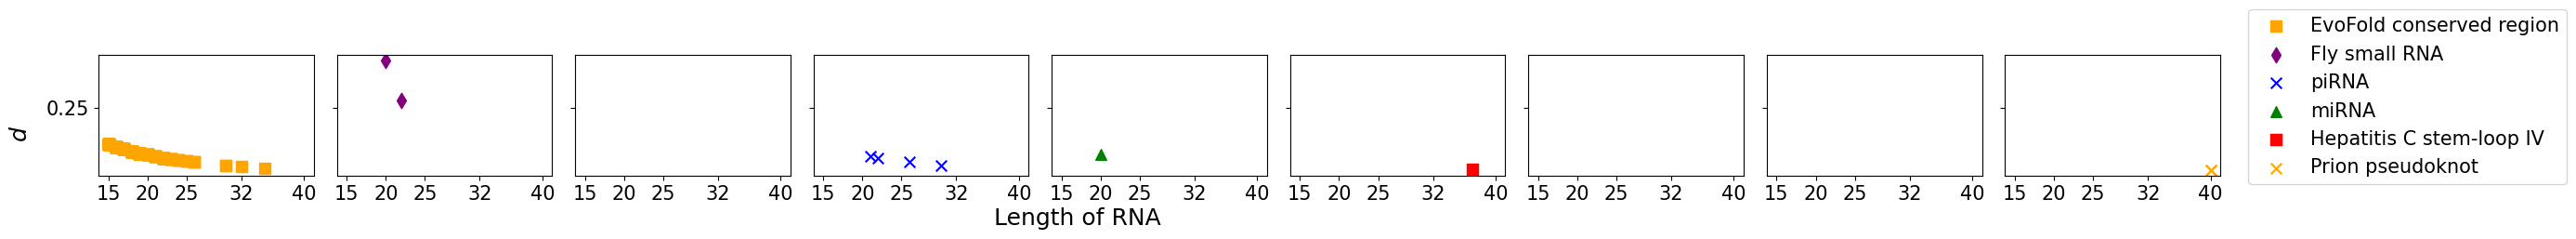

In [86]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 9, figsize=(25, 2), sharex=True, sharey=True)

# Define the types and their corresponding colors and markers
types = [
    ('EvoFold', 'orange', 's', 'EvoFold conserved region'),
    ('Fly small RNA', 'purple', 'd', 'Fly small RNA'),
    ('Histone', 'black', '*', 'Histone 3\' UTR stem-loop'),
    ('piRNA', 'blue', 'x', 'piRNA'),
    ('miRNA', 'green', '^', 'miRNA'),
    ('Hepatitis', 'red', 's', 'Hepatitis C stem-loop IV'),
    ('bronchitis','blue', 'd', 'Infectious bronchitis virus D-RNA'),
    ('TAR', 'brown', '*', 'HIV-1 TAR RNA'),
    ('Prion pseudoknot', 'orange', 'x', 'Prion pseudoknot')
]

# Track which labels have been added
added_labels = set()

for ax, (type_name, color, marker, label) in zip(axs, types):
    #ax.axvline(x=15, color='black', linestyle='--')
    #ax.axvline(x=20, color='black', linestyle='--')
    #ax.axvline(x=25, color='black', linestyle='--')
    #ax.axvline(x=32, color='black', linestyle='--')
    #ax.axvspan(15, 32, color='grey', alpha=0.2)
    ax.set_xticks([15, 20, 25, 32, 40])
    ax.set_yticks([0.25,0.50,0.75])
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
    for name in list(sigBH.keys()):
        if type_name in name[0]:
            if label not in added_labels:
                ax.scatter(len(name[1]), fRNAhammingdistance[name], c=color, marker=marker, s=70, alpha=1.0, label=label)
                added_labels.add(label)
            else:
                ax.scatter(len(name[1]), fRNAhammingdistance[name], c=color, marker=marker, s=70, alpha=1.0)

    
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.7), fontsize=15)

fig.text(0.5, 0.01, 'Length of RNA', ha='center', fontsize=18)
fig.text(0.04, 0.5, r'$d$', va='center', rotation='vertical', fontsize=18)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()    

In [24]:
selected_for_analysis = list(left_names_minus_bottom[0:5001]) + list(left_names_minus) + list(left_names_tot)

In [28]:
with open("../data/selected_for_analysis.pkl","wb") as f:
    pickle.dump(selected_for_analysis,f)

In [3]:
import pickle
with open("../data/selected_for_analysis.pkl","rb") as f:
    selected_for_analysis = pickle.load(f)

EOFError: Ran out of input

In [44]:
len(selected_for_analysis)

7150

In [56]:
len(sigBH)

147

In [66]:
sigBH.keys()

dict_keys([('FR001310|D16617|Hepatitis C stem-loop IV', 'CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT'), ('FR141231|AY133057|Prion pseudoknot', 'TCATGGTGGCGGCTGGGGACAGCCCCACGGTGGTGGTTGG'), ('FR164768||Putative conserved noncoding region (EvoFold)', 'TGCTGAGCGACGAGCTCAGCA'), ('FR176351||Putative conserved noncoding region (EvoFold)', 'TGACGTGGAGGACACGTCA'), ('FR026182||Putative conserved noncoding region (EvoFold)', 'TGGTTCTGTCTTGAACCA'), ('FR040058||Putative conserved noncoding region (EvoFold)', 'TGGCGCCTGGTCACAGGTGCCA'), ('FR033841||Putative conserved noncoding region (EvoFold)', 'TGCTGGGGCGCCAGCA'), ('FR138786||Putative conserved noncoding region (EvoFold)', 'TGGCTCTGCTTGGCAGAGCCA'), ('FR089388||Putative conserved noncoding region (EvoFold)', 'TGCCTGCCTGAGCAGGCA'), ('FR180894||Putative conserved noncoding region (EvoFold)', 'TGATAGGAAACTGTCA'), ('FR143560||Putative conserved noncoding region (EvoFold)', 'TGTCATCACAAGATGACA'), ('FR025156||Putative conserved noncoding region (EvoFold)', 'TGA

In [54]:
hamming = []
distance = []
names = []
for name in selected_for_analysis:
    print(name)
    names.append(name)
    hamming.append(fRNAhammingdistance[tuple(name)])
    distance.append(diagonal_distances[tuple(name)])

['FR000056||Putative conserved noncoding region (EvoFold)'
 'AGATGGATGAGTTGGATCCATCT']
['FR000085||Putative conserved noncoding region (EvoFold)'
 'GTTTTGCCTGGAAGGCAAGAC']
['FR000107||Putative conserved noncoding region (EvoFold)'
 'ACCTGGAAGAATGCCACGGCCAGGT']
['FR000136||Putative conserved noncoding region (EvoFold)'
 'CTTGACAGCTTGTCAAG']
['FR000150||Putative conserved noncoding region (EvoFold)'
 'TGCTGCTGTGCAGCA']
['FR000179||Putative conserved noncoding region (EvoFold)'
 'TGCAGATTGCGATTTGCA']
['FR000203||Putative conserved noncoding region (EvoFold)'
 'TCTGGGTTCTGCCCAGA']
['FR000245|DQ721482|Piwi-interacting RNA (piRNA)'
 'GCATGAAATACAAGGTCAGAAGAGACCTAGG']
['FR000282|DQ610656|Piwi-interacting RNA (piRNA)'
 'TGCATTTGCGCGTGCTCGTGCTTGGCAAT']
['FR000334|DQ596882|Piwi-interacting RNA (piRNA)'
 'GATGAAGGTGGACAGGCCTGGATGGAAAA']
['FR000368|DQ615482|Piwi-interacting RNA (piRNA)'
 'TGGGCCTCGAGGATGTACTCTTTCCCGTT']
['FR000369||Putative conserved noncoding region (EvoFold)'
 'TGGTTTTGTTTCAAAAG

In [79]:
import numpy as np

hamming = []
distance = []
for name in selected_for_analysis:
    hamming.append(fRNAhammingdistance[tuple(name)])
    distance.append(diagonal_distances[tuple(name)])

# Convert distance list to numpy array for sorting
distance_array = np.array(distance)

# Get the sorted indices of the distances
sorted_indices = distance_array.argsort()

# Sort names according to the sorted indices
sorted_names = [selected_for_analysis[i] for i in sorted_indices]
sorted_distance = [distance[i] for i in sorted_indices]
rank_sig_d = []
distance_sig = []
rank = -1
rank_distribution_d = 0
distance_distribution = 0
for indx,name in zip(sorted_indices,sorted_names):
    rank +=1
    name = tuple(name)
    if name in list(sigBH.keys()):
        rank_sig_d.append(rank)
        distance_sig.append(distance[indx])
        if name == ('FR001310|D16617|Hepatitis C stem-loop IV','CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT'):
            rank_distribution_d = rank
            distance_distribution = distance[indx]

hamming_array = np.array(hamming)

# Get the sorted indices of the distances
sorted_indices = hamming_array.argsort()

# Sort names according to the sorted indices
sorted_names = [selected_for_analysis[i] for i in sorted_indices]
sorted_hamming = [hamming[i] for i in sorted_indices]
rank_sig = []
hamming_sig = []
rank = -10
rank_distribution_h = 0
hamming_distribution = 0 
for indx,name in zip(sorted_indices,sorted_names):
    rank +=1
    name = tuple(name)
    if name in list(sigBH.keys()):
        rank_sig.append(rank)
        hamming_sig.append(hamming[indx])
        if name == ('FR001310|D16617|Hepatitis C stem-loop IV','CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT'):
            rank_distribution_h = rank
            hamming_distribution = hamming[indx]
            print(hamming_distribution)

0.05405405405405406


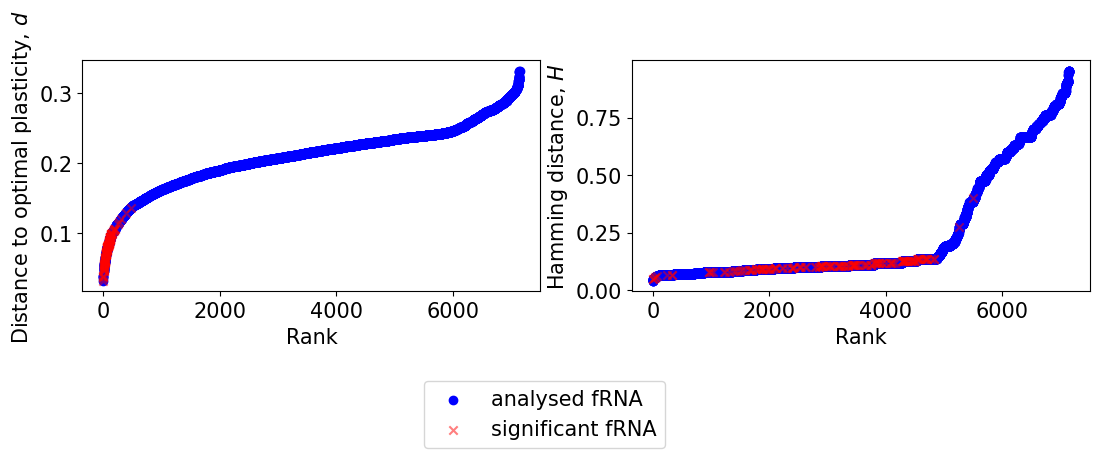

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
ax1.scatter(np.arange(0,len(distance)),sorted_distance, c='blue', marker='o', alpha=1.0, label='analysed fRNA')
ax1.scatter(rank_sig_d,distance_sig, c='red', marker='x', alpha=0.5, label='significant fRNA')
#ax1.scatter(rank_distribution_d, distance_distribution, c='black', marker='s', alpha=1.0)
ax1.set_xlabel('Rank', fontsize=15)
ax1.set_ylabel('Distance to optimal plasticity, $d$', fontsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)


ax2.scatter(np.arange(0,len(hamming)),sorted_hamming, c='blue', marker='o', alpha=1.0, label='analysed fRNA')
ax2.scatter(rank_sig,hamming_sig, c='red', marker='x', alpha=0.5, label='significant fRNA')
#ax2.scatter(rank_distribution_h, hamming_distribution, c='black', marker='s', alpha=1.0)
ax2.set_xlabel('Rank', fontsize=15)
ax2.set_ylabel('Hamming distance, $H$', fontsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
plt.subplots_adjust(hspace=15) 
handles, labels = [], []
for ax in [ax1,ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.38, -0.3), fontsize=15)

In [93]:
import numpy as np

hamming = []
distance = []
for name in selected_for_analysis:
    hamming.append(fRNAhammingdistance[tuple(name)])
    distance.append(diagonal_distances[tuple(name)])

# Convert distance list to numpy array for sorting
distance_array = np.array(distance)

# Get the sorted indices of the distances
sorted_indices = distance_array.argsort()

# Sort names according to the sorted indices
sorted_names = [selected_for_analysis[i] for i in sorted_indices]
sorted_distance = [distance[i] for i in sorted_indices]
rank_sig_d = []
distance_sig = []
rank = -1
rank_distribution_d = 0
distance_distribution = 0
for indx,name in zip(sorted_indices,sorted_names):
    rank +=1
    name = tuple(name)
    if name in list(merged_dict.keys()):
        rank_sig_d.append(rank)
        distance_sig.append(distance[indx])
        if name == ('FR001310|D16617|Hepatitis C stem-loop IV','CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT'):
            rank_distribution_d = rank
            distance_distribution = distance[indx]

hamming_array = np.array(hamming)

# Get the sorted indices of the distances
sorted_indices = hamming_array.argsort()

# Sort names according to the sorted indices
sorted_names = [selected_for_analysis[i] for i in sorted_indices]
sorted_hamming = [hamming[i] for i in sorted_indices]
rank_sig = []
hamming_sig = []
rank = -10
rank_distribution_h = 0
hamming_distribution = 0 
for indx,name in zip(sorted_indices,sorted_names):
    rank +=1
    name = tuple(name)
    if name in list(merged_dict.keys()):
        rank_sig.append(rank)
        hamming_sig.append(hamming[indx])
        if name == ('FR001310|D16617|Hepatitis C stem-loop IV','CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT'):
            rank_distribution_h = rank
            hamming_distribution = hamming[indx]
            print(hamming_distribution)

0.05405405405405406


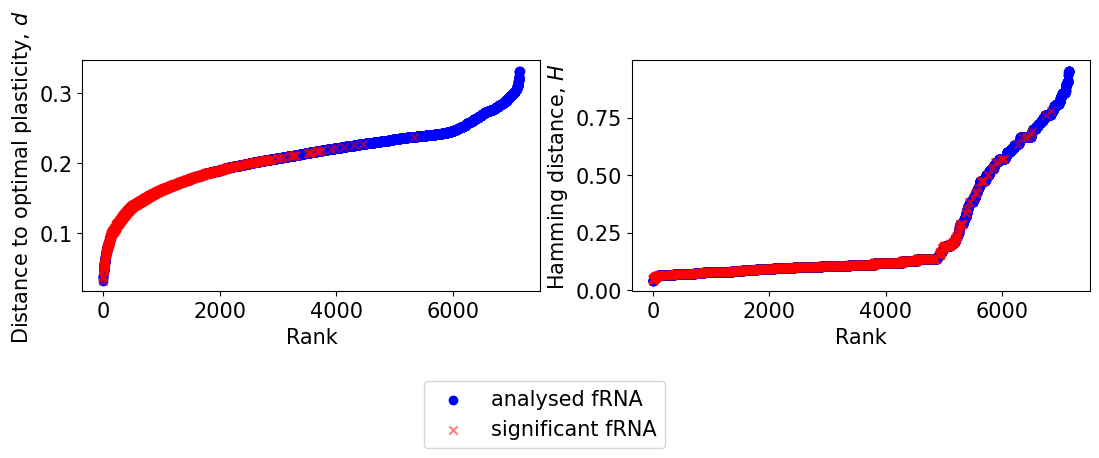

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
ax1.scatter(np.arange(0,len(distance)),sorted_distance, c='blue', marker='o', alpha=1.0, label='analysed fRNA')
ax1.scatter(rank_sig_d,distance_sig, c='red', marker='x', alpha=0.5, label='significant fRNA')
#ax1.scatter(rank_distribution_d, distance_distribution, c='black', marker='s', alpha=1.0)
ax1.set_xlabel('Rank', fontsize=15)
ax1.set_ylabel('Distance to optimal plasticity, $d$', fontsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)


ax2.scatter(np.arange(0,len(hamming)),sorted_hamming, c='blue', marker='o', alpha=1.0, label='analysed fRNA')
ax2.scatter(rank_sig,hamming_sig, c='red', marker='x', alpha=0.5, label='significant fRNA')
#ax2.scatter(rank_distribution_h, hamming_distribution, c='black', marker='s', alpha=1.0)
ax2.set_xlabel('Rank', fontsize=15)
ax2.set_ylabel('Hamming distance, $H$', fontsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
plt.subplots_adjust(hspace=15) 
handles, labels = [], []
for ax in [ax1,ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.38, -0.3), fontsize=15)

In [95]:
len(merged_dict)

1440

In [84]:
fRNAprob2[('FR001310|D16617|Hepatitis C stem-loop IV','CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT')]

0.43645017760912713

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


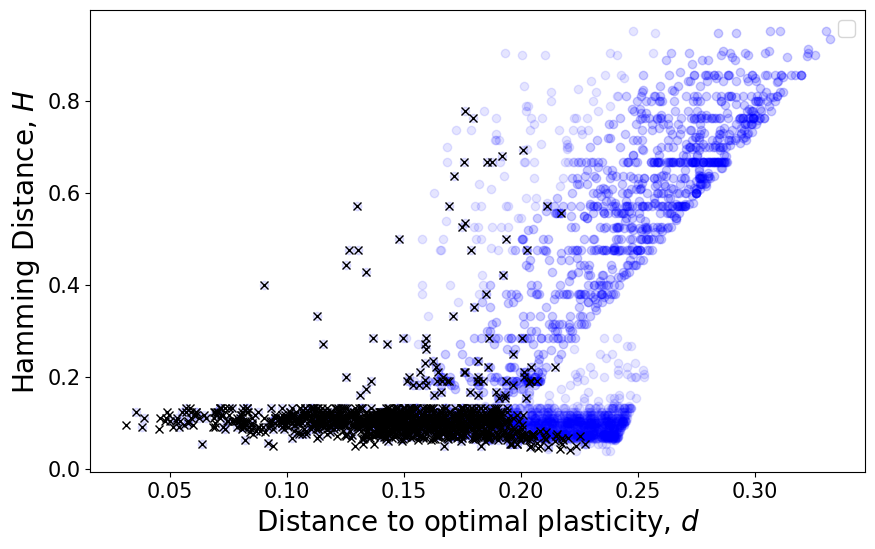

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(distance,hamming, c='blue', marker='o', alpha=0.1)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus_bottom.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

In [51]:
types = ['EvoFold', 'Fly small RNA', 'Histone', 'piRNA', 'miRNA']
for name in merged_dict.keys():
    if all(not any(t in element for t in types) for element in name):
        print(name)


('FR147843|AF042843,AF113937,AF113938,AF113939|Prion pseudoknot', 'CCACGGTGGTGGCTGGGGACAGCCACATGGTGGTGGTGGT')
('FR143768|U75389|Prion pseudoknot', 'TCATGGTGGTGGCTGGGGACAGCCTCATGGTGGTGGCTGG')
('FR116399|AB049090,AB057606|Hepatitis C stem-loop IV', 'TGGTGCCTACTCCTACTTTCTGTAGGGGTAGGCATTT')
('FR036505|AB049099|Hepatitis C stem-loop IV', 'TTGTGCCTACTCCTACTTTCCGTAGGAGTAGGCGTCT')
('FR141231|AY133057|Prion pseudoknot', 'TCATGGTGGCGGCTGGGGACAGCCCCACGGTGGTGGTTGG')
('FR155972|AB057684|Hepatitis C stem-loop IV', 'TGGTGCCTACTCCTACTCTCCGTAGGGGTAGGCATTT')
('FR134483|AF096667|Trans-activation response element (TAR)', 'TCTCAGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTGACTGAGA')
('FR048128|D49374|Hepatitis C stem-loop IV', 'CTTTGCCTACTCCTACTTACCGTAGGGGTAGGCATTT')
('FR067019|AB030907,AY232736,AY232737,AY232738,AY232742,AY232743,AY232744,AY232745,AY232746,AY232747,D00828,D10988|Hepatitis C stem-loop IV', 'CTTTGCCTACTCCTACTTAGCGTAGGAGTAGGCATCT')
('FR164798|AF511949|Hepatitis C stem-loop IV', 'TTTTGCCTACTCCTGCTTGCCG

In [52]:
fRNAfolds[('FR096368|AY133058|Prion pseudoknot', 'TCACGGTGGTGGCTGGGGACAGCCCCACGGTGGTGGTGGC')]

['((((.((((.(((((....))))))))).)))).......',
 '.(((.((((.(((((....))))))))).)))........']

In [53]:
fRNAfolds[('FR099140|U52596|Infectious bronchitis virus D-RNA', 'GAAAGATAGGCATGTAGCTTGATTACCTATATGTCTATCGCC')]

['....(((((((((((((.........)))))))))))))...',
 '....(((((((((((((.(.....).)))))))))))))...']

In [54]:
fRNAfolds[('FR033114|D00825,D10749|Hepatitis C stem-loop IV', 'TTCTGCCTACTCCTGCTTGCTGCAGGGGTAGGCATCT')]

['...(((((((((((((.....)))))))))))))...',
 '....((((((((((((.....))))))))))))....']

In [55]:
fRNAfolds[('FR134483|AF096667|Trans-activation response element (TAR)', 'TCTCAGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTGACTGAGA')]

['((((((((((.(((((...((((......)))))))))))))))))))',
 '.(((((((((.(((((...((((......)))))))))))))))))).']